# Voronoï diagrams

[Voronoï diagrams](https://en.wikipedia.org/wiki/Voronoi_diagram) have quite many usages (see e.g. this article: https://towardsdatascience.com/the-fascinating-world-of-voronoi-diagrams-da8fc700fa1b)

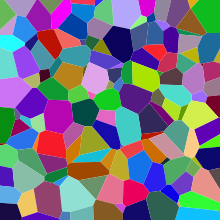


In 3D design, by using the vertices of a voronoï diagram filling a plane, one can generate a mesh that has good structural property, and has an "organic" feel to it.


Unfortunately, Onshape does not appear to have anything that allows to generate a voronoï diagram. 

All'right, let's implement Voronoï diagrams in Onshape's FeatureScript, because how hard can that be ?


## Initial research


After some searches, it appears that
- There is no "easy" way to generate a Voronoï diagram
- Generating a Voronoï diagram is often implemented with it's dual operation, that is, generating a [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation) of a set of points.
- There is a rather great blogpost that breaks down an implementation of the Delaunay triangulation: https://ianthehenry.com/posts/delaunay/

<div class="alert alert-block alert-info">
    <b>Note:</b> This notebook is heavily based on the above blog post - be sure to read it if you want to understand everything:
    <a href="https://ianthehenry.com/posts/delaunay/"> https://ianthehenry.com/posts/delaunay/</a>
</div>


So here goes myself, following the blog post, and converting the code to Onshape's Feature script ... until I find out that some important parts have been left out.

Being not so well acquainted with Feature script, and given the clumsyness of iterating with it, I decide to make a first implementation im Python, so that I can get a good grasp of the various untold parts, and then make a Feature script implementation.

# Delaunay triangulation

The first step is to extract the code given in the blog post, and convert it to Python (from javascript).

## QuarterEdge

Let's first implement the QuarterEdge structure. As explained in the blog post, QuarterEdge are oriented edges between two vertices, except their representation is not straightforward:

A QuarterEdge is a data structure made of

- the origin vertex of the edge they represent (in the `origin` field, named `data` in the blog post - this is a very bad name IMO).
- the next edge starting from origin (clockwise)
- finally, a field named `rot`, that points to the dual of the edge (whose origin is the *leftward* face when drawing the graph).

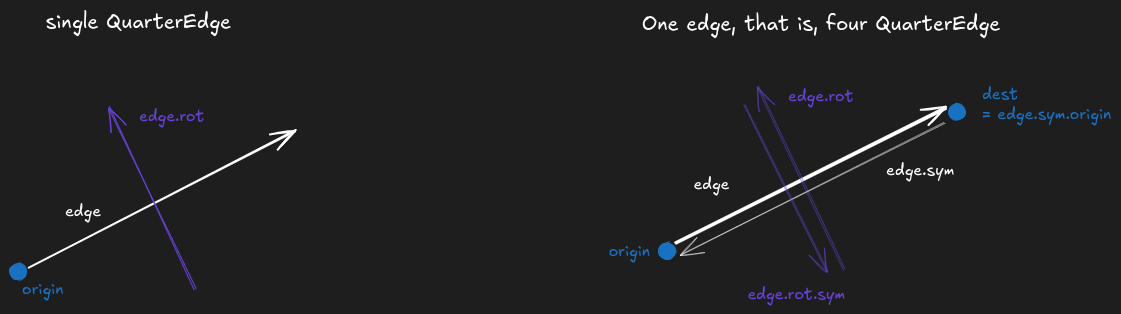

See the blog post for additional explanation, and very nice interactive diagrams.

Note that the "dual" QuarterEdges do not have anything in the `origin` field - it may have been better to use a different structure for them.


In [1]:
from typing import NamedTuple
from dataclasses import dataclass

class Point(NamedTuple):
    """Points are immutable, so using a NamedTuple is particularly appopriate"""
    x: int
    y: int

    def __repr__(self):
        return f"({self.x}, {self.y})"

        
@dataclass
class QuarterEdge:
    """
    A quarter edge 
    origin: starting point of this edge
    next: next edge starting from origin
    rot: dual edge
    """
    origin: Point | None
    next: "QuarterEdge"
    rot: "QuarterEdge"
    color: str = "blue"

    @property
    def sym(self) -> "QuarterEdge":
        """Reverse direction"""
        return self.rot.rot

    @property
    def tor(self) -> "QuarterEdge":
        return self.rot.rot.rot

    @property
    def prev(self) -> "QuarterEdge":
        """Previous edge starting from data"""
        return self.rot.next.rot
        
    @property
    def lnext(self) -> "QuarterEdge":
        """next edge in triangle (keeping same orientation"""
        return self.tor.next.rot
        
    @property
    def dest(self) -> Point:
        """End point of the edge"""
        return self.sym.origin

    def __repr__(self):
        return f"{self.origin} -> {self.dest}"

    def id(self):
        """Returns a frozenset containing both vertices: the id of an edge and it's symmetrical are the same"""
        if self.origin is None:
            raise ValueError("Dual QuarterEdge in dual does not have coords")
        return frozenset( [self.origin, self.dest] )

['/home/sapristi/dev/notebooks/notebooks', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/sapristi/dev/notebooks/.venv/lib/python3.12/site-packages']
/home/sapristi/dev/notebooks/notebooks


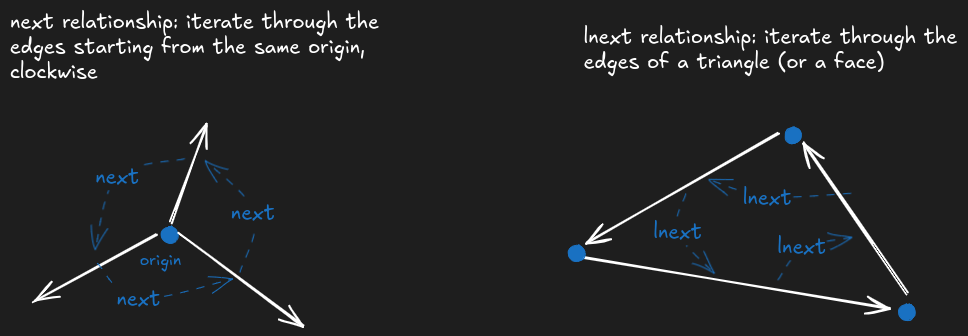

## First operations: makeEdge, splice, and makeTriangle

Next we add some operations on `QuadEdges`:
- `makeEdge`, to create the four QuadEdges relative to a given `origin` and `dest` points.
- `splice`, that is used to link Edges together, and create the graph structure.

In [2]:
def makeEdge(origin: Point, dest: Point):
    """Creates an edge from start to end:
    Creates an oriented edge, it's symmetrical, and the two dual edges"""
    startEnd = QuarterEdge(origin=None, next=None, rot=None)
    leftRight = QuarterEdge(origin=None, next=None, rot=None)
    endStart = QuarterEdge(origin=None, next=None, rot=None)
    rightLeft = QuarterEdge(origin=None, next=None, rot=None)
    
    startEnd.origin = origin
    endStart.origin = dest
    
    startEnd.rot = leftRight
    leftRight.rot = endStart
    endStart.rot = rightLeft
    rightLeft.rot = startEnd
    
    # normal edges are on different vertices,
    # and initially they are the only edges out
    # of each vertex
    startEnd.next = startEnd
    endStart.next = endStart
    
    # but dual edges share the same face, 
    # so they point to one another
    leftRight.next = rightLeft
    rightLeft.next = leftRight
    
    return startEnd

Now you might wonder, if we can create a single Edge, what does the `next` relationship looks like for it ? Turns out it's very simple: the `next` item of each QuarterEdge is itself.

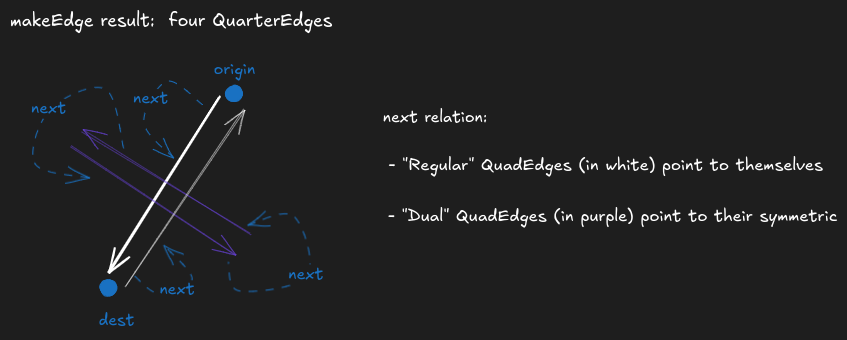

In [3]:
def swapNexts(a: QuarterEdge, b: QuarterEdge):
  a.next, b.next = b.next, a.next

def splice(a: QuarterEdge, b: QuarterEdge):
    """Links two edges together (they are expected to have the same origin"""
    swapNexts(a.next.rot, b.next.rot)
    swapNexts(a, b)


Finally, we can implement `makeTriangle`: make three edges, and splice each pair at their common point:

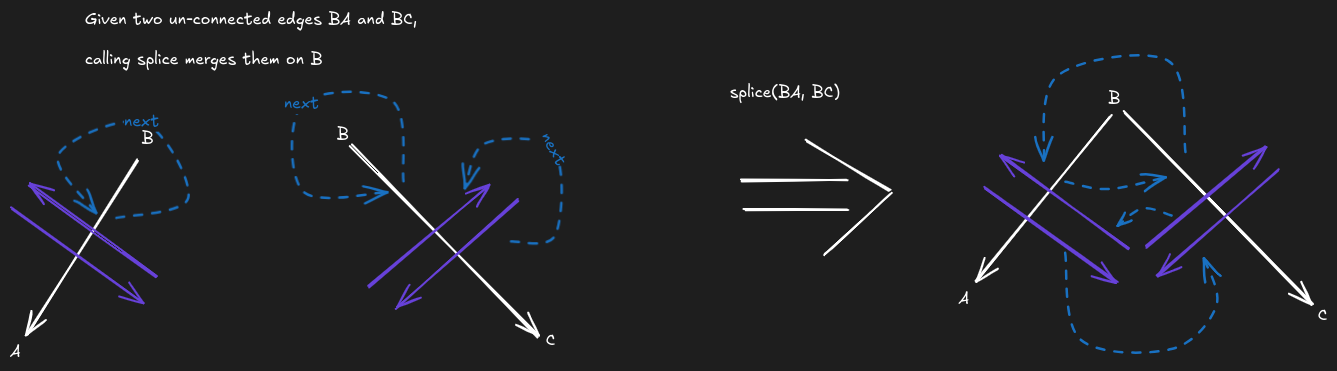

In [4]:
def makeTriangle(a: Point, b: Point, c: Point):
  ab = makeEdge(a, b)
  bc = makeEdge(b, c)
  ca = makeEdge(c, a)

  splice(ab.sym, bc)
  splice(bc.sym, ca)
  splice(ca.sym, ab)

  return ab
    

Which gives us a connected triangle:

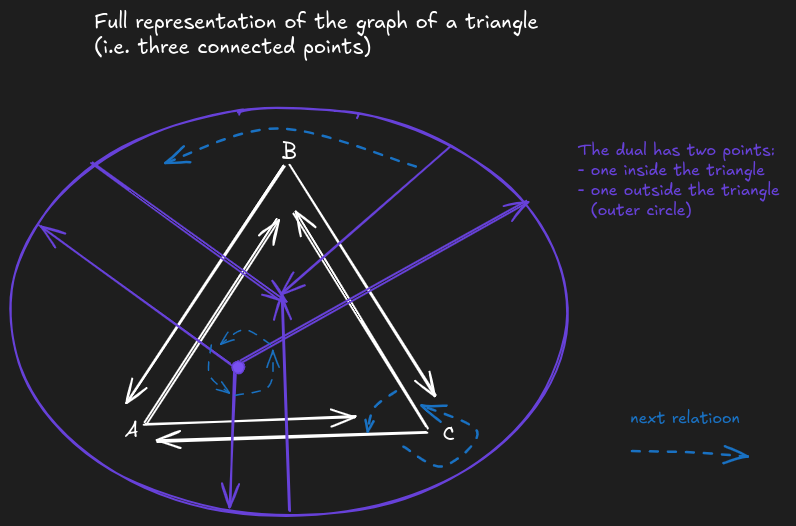

## Interlude: drawing the graph

In order to more easily make sense of (and debug) our code, let's add some visualisation functions.

### Drawing edges

We'll start with a function to draw a QuadEdge: 
- line from origin to dest
- text label with coordinates of each point
- optional orientation: colored in red near dest

In [5]:
from ipycanvas import Canvas
import numpy as np
import random


WIDTH = 500
HEIGHT = 300
canvas = Canvas(width=WIDTH, height=HEIGHT)
 

def draw_edge(canvas, edge, orientation=False):
    colors = {edge.color, edge.sym.color}
    if len(colors) > 1:
        color = (colors  - {"blue"}).pop()
    else:
        color = "blue"
    canvas.stroke_style = color
    canvas.stroke_line(edge.origin.x, edge.origin.y, edge.dest.x, edge.dest.y)
    if orientation:
        canvas.stroke_style = "red"
        start_x = edge.dest.x - (edge.dest.x - edge.origin.x) / 10
        start_y = edge.dest.y - (edge.dest.y - edge.origin.y) / 10
        canvas.stroke_line(start_x, start_y, edge.dest.x, edge.dest.y)
    canvas.fill_text(str(edge.origin), edge.origin.x, edge.origin.y)
    canvas.fill_text(str(edge.dest), edge.dest.x, edge.dest.y)
    edge.color = "blue"
    edge.sym.color = "blue"

points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
draw_edge(canvas, triangle, orientation=True)
draw_edge(canvas, triangle.lnext, orientation=True)
draw_edge(canvas, triangle.lnext.lnext, orientation=True)
canvas

['/home/sapristi/dev/notebooks/notebooks', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/home/sapristi/dev/notebooks/.venv/lib/python3.12/site-packages']
/home/sapristi/dev/notebooks/notebooks


Canvas(height=300, width=500)

### Walking the graph to draw all the edges

In [6]:
def walk(edge: QuarterEdge):
    """To walk the graph, starting from an edge:
    - walk edge.lnext (next edge of the same face)
    - walk all the edges starting from the same point (next relation)
    """
    walked = set()
    to_walk = {edge.id(): edge}
    while len(to_walk) > 0:
        edge_id, edge = to_walk.popitem()
        yield edge
        walked.add(edge_id)
        
        if not edge.lnext.id() in walked | to_walk.keys():
            to_walk[edge.lnext.id()] = edge.lnext

        neighbour = edge.next
        while True:
            if not neighbour.id() in walked | to_walk.keys():
                to_walk[neighbour.id()] = neighbour
            neighbour = neighbour.next
            if neighbour.id() == edge.id():
                break

In [7]:
def draw_all_edges(canvas, start_edge: QuarterEdge):
    for edge in walk(start_edge):
        draw_edge(canvas, edge)

In [8]:
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
canvas = Canvas(width=WIDTH, height=HEIGHT)
draw_all_edges(canvas, triangle)
canvas

Canvas(height=300, width=500)

## Other operations

Finally, we add the `insertPoint` function, that inserts a new point, and all related edges, inside a face (determined by a given QuarterEdge).

**Note:** taken as-is from the origin blog post.

In [9]:
def connect(a: QuarterEdge, b: QuarterEdge): 
    """Creates a new edge between `a.dest` and `b.origin` """
    newEdge = makeEdge(a.dest, b.origin)
    splice(newEdge, a.lnext)
    splice(newEdge.sym, b)
    return newEdge

def sever(edge: QuarterEdge):
    splice(edge, edge.prev)
    splice(edge.sym, edge.sym.prev)

def insertPoint(polygonEdge: QuarterEdge, point: Point) -> QuarterEdge: 
    firstSpoke = makeEdge(polygonEdge.origin, point)
    splice(firstSpoke, polygonEdge)
    spoke = firstSpoke
    while True:
        spoke = connect(polygonEdge, spoke.sym)
        spoke.rot.origin = None
        spoke.tor.origin = None
        polygonEdge = spoke.prev
        if (polygonEdge.lnext == firstSpoke):
            break
    return firstSpoke

def flip(edge: QuarterEdge): 
    a = edge.prev
    b = edge.sym.prev
    splice(edge, a)
    splice(edge.sym, b)
    splice(edge, a.lnext)
    splice(edge.sym, b.lnext)
    edge.origin = a.dest
    # edge.dest = b.dest - but cannot set dest
    edge.sym.origin = b.dest
    return edge

As expected, starting from an edge, drawing `edge`, `edge.lnext` and `edge.lnext.lnext` allows to draw the three edges of a triangle.

In [10]:
triangle

(10, 10) -> (200, 300)

In [11]:
triangle.lnext

(200, 300) -> (400, 10)

In [12]:
triangle.lnext.lnext

(400, 10) -> (10, 10)

Ok let's try this: we'll draw a triangle, in which we inserted a point:

In [13]:
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)

insertPoint(triangle, Point(100, 100))
canvas = Canvas(width=WIDTH, height=HEIGHT)
draw_all_edges(canvas, triangle)
canvas

Canvas(height=300, width=500)

Sounds good ! Let's make this interactive:

In [14]:
import ipywidgets as ipw

def on_mouse_down(point: Point):
    print("Mouse down event:", point)
    insertPoint(self.triangle, point)
    

class NaiveInsert:
    def __init__(self, points):
        self.points =  points
        self.canvas = Canvas(width=WIDTH, height=HEIGHT)
        self.log_output = ipw.Output()
        
        @self.log_output.capture()
        def handle_point(x, y):
            point = Point(int(x), int(y))
            self.handle_add_point(point)
            
        self.canvas.on_mouse_down(handle_point)
        self.layout = self.make_layout()
        self.reset()

    def make_layout(self):
        """Makes layout to display"""
        reset_button = ipw.Button(description="Reset")
        reset_button.on_click(self.reset)
        vbox = ipw.VBox( 
            [ 
                ipw.HTML("Click on the figure to add a new point:"), 
                ipw.Box([self.canvas], layout=ipw.Layout(border='solid')) 
            ])
        return ipw.HBox( [vbox, ipw.VBox([reset_button, self.log_output]) ])
        
    def handle_add_point(self, point):
        print("Mouse down event:", point)
        insertPoint(self.triangle, point)
        self.draw()
    
    def reset(self, *args, **kwargs):
        self.triangle = makeTriangle(*self.points)
        self.log_output.clear_output()
        self.draw()
            
    def draw(self):
        self.canvas.clear()
        draw_all_edges(self.canvas, self.triangle)

    def display(self):
        return self.layout

fig = NaiveInsert(points=[
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
])
fig.display()

We can notice several things:
- basic insertion seems to work, although it is always inserted from the same edge (which is expected)
- Somehow, the first insertion links the four first vertices, we'll check on that later.


What we need now, is to find the right face to insert a point to.

## Finding the face to insert a new point

The blog gives some explanations about how to do that, although some parts are left out.

First, let's add an `orientation` function:

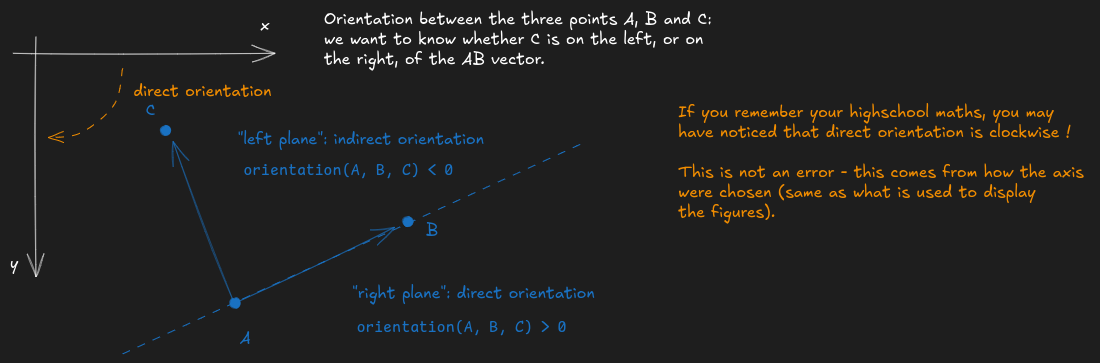

In [15]:
def orientation(t1: Point, t2: Point, t3: Point):
    """Calculates the relative orientation of the three given points"""
    u_x = t2.x - t1.x
    u_y = t2.y - t1.y
    v_x = t3.x - t1.x
    v_y = t3.y - t1.y
    return u_x * v_y - u_y * v_x

In [16]:
orientation(Point(0, 0), Point(1, 0), Point(0, 1))

1

Now, the generic algorithm to find the face where a new point is inserted is explained in the blog post, but I still made some drawings to help make sense of it.

1. We iterate on our structure, either going left or right :

    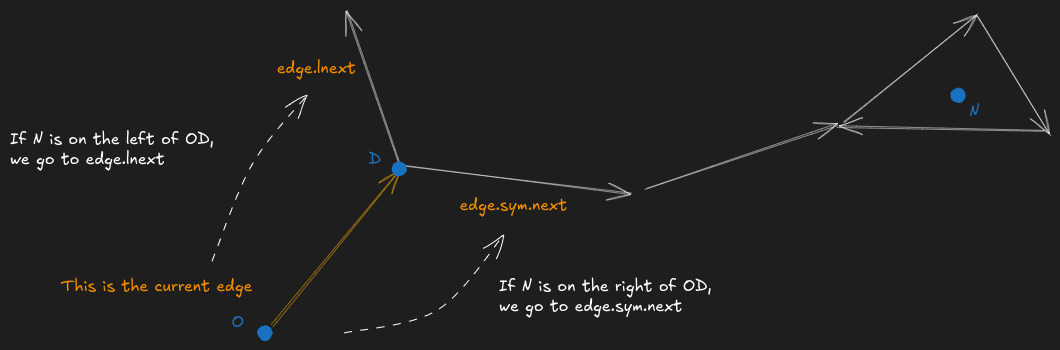

2. In order to know when to stop, we keep in memory the last three moves that we made. If the last three moves were all to the left, or all to the right, then we found the face containing the points.

    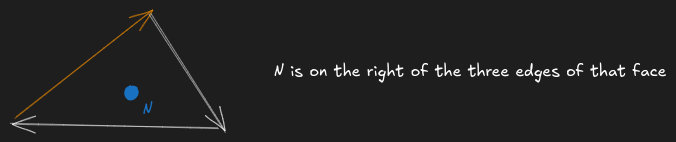

   
    This is what the `Stack` structure below is here for.

In [17]:
class Stack:
    def __init__(self):
        self.a = None
        self.b = None
        self.c = None
    
    def push(self, value):
        self.c = self.b
        self.b = self.a
        self.a = value

    def values(self):
        return {self.a, self.b, self.c}

class OutOfBoundingTriangleException(Exception):
    pass

def find_containing_triangle(edge: QuarterEdge, point: Point):
    """Walks the graph until a triangle containing the point is found
    Point on edge is not handled yet
    """
    stack = Stack()
    current = edge
    visited = set()
    while True:
        if stack.values() ==  {"l"}:       
            # If the points is on the left of the three previous edges, then 
            # it is inside the face
            return current
        if stack.values() == {"r"}:
            return current.sym
        
        if id(current) in visited:
            raise OutOfBoundingTriangleException()
        visited.add(id(current))
        
        if orientation(current.origin, current.dest, point) > 0:
            """
            point is on the right of current edge
            so we add `"r"` to the stack, and go to the next edge of the face
            """
            stack.push("r")
            current = current.sym.next
        
        else:
            """
            point is on the left of current edge
            so we add `"l"` to the stack, and go to the next edge of the face
            """
            stack.push("l")
            current = current.lnext

In [18]:
points = [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
]
triangle = makeTriangle(*points)
find_containing_triangle(triangle, Point(100, 100))

(10, 10) -> (200, 300)

In [19]:
class InsertInFace(NaiveInsert):
    
    def handle_add_point(self, point):
        print("Mouse down event:", point)
        try:
            insert_loc = find_containing_triangle(self.triangle, point)
        except OutOfBoundingTriangleException:
            print(f"ERROR: Cannot insert {point}: out of bounding triangle")
            return
        insertPoint(insert_loc, point)
        self.draw()

fig = InsertInFace(points=[
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
])
fig.display()

Working ! Each time we insert a new point, it is linked to the three vertices of the containing triangle.

Detecting points out of the bounding triangle works as well. What remains to do, is to flip edges so as to keep the Delaunay property of the triangulation.

## Flipping edges, and delaunay insertion

In [20]:
def point_in_circle(
    t1: Point, t2: Point, t3: Point, a: Point
) -> bool:
    """
    Whether `a` is inside the circumscribed circle of t1, t2 and t3.
    """
    if not orientation( t1, t2, t3) > 0:
        t2, t3 = t3, t2
    make_row = lambda p: [ p.x, p.y, p.x*p.x + p.y*p.y, 1]
    return np.linalg.det(np.array([
        make_row(t1), 
        make_row(t2), 
        make_row(t3), 
        make_row(a)
    ])) > 0

In [21]:
def check_edge(edge: QuarterEdge, outer_edge_ids: set) -> list[QuarterEdge]:
    orig = edge.origin
    end = edge.dest
    left_third = edge.next.dest
    right_third = edge.prev.dest
    print(f"Checking {edge}: left {left_third} right {right_third}")
    edge.color = "green"
    if point_in_circle(orig, end, left_third, right_third):
        if edge.id() in outer_edge_ids:
            print(f"Warning: {edge.id()} in outer_edge_ids")
            return [edge.sym.next.next]
        print(f"flipping {edge}")
        flipped = flip(edge)
        flipped.color="yellow"
        return [flipped.sym.next, flipped.sym.prev.sym]
    return [edge.sym.next.next]

def check_edges(edge: QuarterEdge, outer_edge_ids: set):
    already_checked = set()
    to_check = [ edge ]
    while to_check:
        edge = to_check.pop()
        to_check_new_edges = check_edge(edge, outer_edge_ids)
        already_checked.add(edge.id())
        for to_check_new in to_check_new_edges:
            if to_check_new.id() not in already_checked:
                to_check.append(to_check_new)
        
def insert_delaunay(edge: QuarterEdge, point: Point, outer_edge_ids: set):
    insert_loc = find_containing_triangle(edge, point)
    spoke = insertPoint(insert_loc, point)
    spoke.color = "green"
    check_edges(spoke.next, outer_edge_ids)
    return spoke

In [22]:
class InsertDelaunay(NaiveInsert):
    def __init__(self, points):
        super().__init__(points)
        self.outer_edge_ids = [
            self.triangle.id(), self.triangle.next.id(), self.triangle.sym.next.id(),
        ]
    def handle_add_point(self, point):
        print("Mouse down event:", point)
        insert_delaunay(self.triangle, point, self.outer_edge_ids)
        self.draw()


fig = InsertDelaunay(points= [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
])
fig.display()

## Bonus

### Highlight edge operations

Here, we implement a representation that allows naviagating the graph, with the `next`, `lnext` and `rnext` operations (in the same way that is done in the blog post).

Notes:
- we do not display edge orientation
- `rnext` operation corresponds to `.sym.next`

In [23]:
class ShowOperations(NaiveInsert):
    def __init__(self, points):
        super().__init__(points)

        self.log_output.clear_output()
        self.reset()
        self.draw()
        self.current = self.triangle
        self.current.color = "green"
        self.draw()

    def reset(self,  *args, **kwargs):
        self.triangle = makeTriangle(*self.points)
        self.outer_edge_ids = [
            self.triangle.id(), self.triangle.next.id(), self.triangle.sym.next.id(),
        ]
        for point in [
            Point(130, 70), Point(270, 70), Point(200, 200), Point(200, 120)
        ]:
            
            with self.log_output:
                insert_delaunay(self.triangle, point, self.outer_edge_ids)
        self.log_output.clear_output()
        self.draw()
        self.current = self.triangle
        self.current.color = "green"
        self.draw()

    def handle_add_point(self, point):
        pass

    def make_layout(self):
        """Makes layout to display"""
        reset_button = ipw.Button(description="Reset")
        reset_button.on_click(self.reset)
        next_button = ipw.Button(description="Next")
        lnext_button = ipw.Button(description="LNext")
        rnext_button = ipw.Button(description="RNext")
        
        def handle_next(*args):
            self.current = self.current.next
            self.current.color = "green"
            self.draw()

        def handle_lnext(*args):
            self.current = self.current.lnext
            self.current.color = "green"
            self.draw()

        def handle_rnext(*args):
            self.current = self.current.sym.next
            self.current.color = "green"
            self.draw()
        next_button.on_click(handle_next)
        lnext_button.on_click(handle_lnext)
        rnext_button.on_click(handle_rnext)
        
        vbox = ipw.VBox( 
            [ 
                ipw.HTML("Click on the figure to add a new point:"), 
                ipw.Box([self.canvas], layout=ipw.Layout(border='solid')) 
            ])
        return ipw.HBox( [vbox, ipw.VBox([reset_button, next_button, lnext_button, rnext_button, self.log_output]) ])

        
fig = ShowOperations(points= [
    Point(10, 10), 
    Point(200, 300),
    Point(400, 10)
])
fig.display()

### Polygons

Can we start with any polygon, instead of a triangle ? Let's try out !

In [24]:
def makePolygon(points: list[Point]):
    edges = []
    for i, origin in enumerate(points):
        dest_i = (i + 1) % len(points)
        dest = points[dest_i]
        edges.append(makeEdge(origin, dest))

    for i, edge in enumerate(edges):
        lnext_edge_i = (i + 1) % len(edges)
        lnext_edge = edges[lnext_edge_i]
        print(f"Joining {edge.sym}, {lnext_edge}")
        splice(edge.sym, lnext_edge)

    return edges[0]

In [25]:
class InsertDelaunayPolygon(NaiveInsert):
    def __init__(self, points):
        super().__init__(points)
        self.outer_edge_ids = []
        current = self.triangle
        while True:
            if current.id() in self.outer_edge_ids:
                break
            
            self.outer_edge_ids.append(current.id())
            current = current.sym.next
        
    def handle_add_point(self, point):
        print("Mouse down event:", point)
        insert_delaunay(self.triangle, point, self.outer_edge_ids)
        self.draw()

    def reset(self, *args, **kwargs):
        self.triangle = makePolygon(self.points)
        self.log_output.clear_output()
        self.draw()
    

In [26]:
points = [
    Point(10, 10), 
    Point(10, 270), 
    Point(200, 270),
    Point(400, 150),
    Point(300, 50)
]

fig = InsertDelaunayPolygon(points)
fig.display()

Joining (10, 270) -> (10, 10), (10, 270) -> (200, 270)
Joining (200, 270) -> (10, 270), (200, 270) -> (400, 150)
Joining (400, 150) -> (200, 270), (400, 150) -> (300, 50)
Joining (300, 50) -> (400, 150), (300, 50) -> (10, 10)
Joining (10, 10) -> (300, 50), (10, 10) -> (10, 270)


This seems to mostly work as expected, which is very nice (this means we can start with just any convex face , instead of computing the bounding triangle of a face e.g.).

Note however that for the first inserted point, we do not correctly detect when it's outside the polygon.

After the first inserted point, we end up with a bunch of triangles already, so there probably won't be any deep issue.

# Conclusion

In this blogpost, we re-implemented an algorithm for Delaunay triangulation. Drawing the graphical representation of the object we work with was an essential part of the work, because it allowed to quickly detect flaws.

Note that there is one case that is not treated in the implem: if the inserted point is exactly on an existing edge (in this case, we should delete the edge).